# Data preprocessing

In [3]:
import pandas as pd

data = pd.read_csv("HistoricalData_1727182541271.csv")
data = data["Close/Last"]

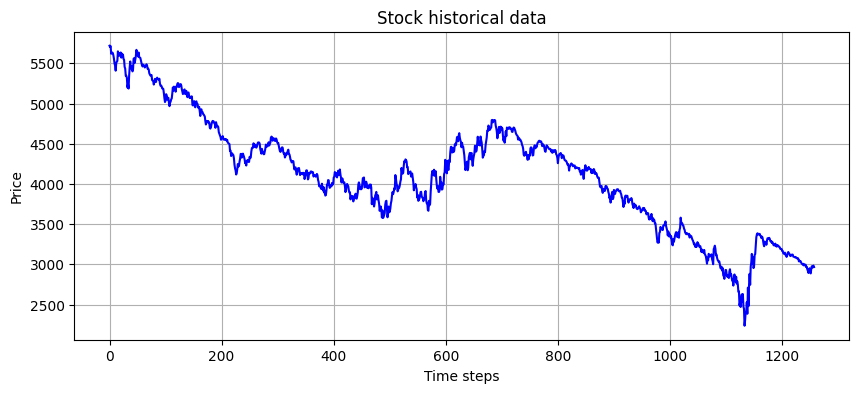

In [4]:
import matplotlib.pyplot as plt
# Plot yteach and predictions
plt.figure(figsize=(10, 4))
plt.plot(data, color='blue')

# Add labels and legend
plt.title("Stock historical data")
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.grid(True)

# Display the plot
plt.show()

# Conventional Reservoir

In [24]:
import numpy as np

def apply_sparsity(W: np.ndarray, sparsity: float) -> np.ndarray:
    """
    Applies sparsity to the given matrix W.
    
    Parameters:
        - W: The matrix to which sparsity will be applied.
        - sparsity: The fraction of elements to be zeros (0 <= sparsity < 1).
    
    Returns:
        The modified matrix with applied sparsity
    """
    total_elements = W.size
    num_nonzero = int(total_elements * sparsity)      
    indices = np.random.choice(np.arange(total_elements),
                            size=num_nonzero,
                            replace=False)
    W.flat[indices] = 0
    return W

def has_valid_eigenvalues(W: np.ndarray) -> bool:
    """
    Checks if the matrix W has no zero eigenvalues.
    
    Parameters:
        - W: The input matrix whose eigenvalues will be checked.
    
    Returns:
        True if the matrix has non-zero eigenvalues, otherwise False.
    """
    eigenvalues = np.linalg.eigvals(W)
    return max(abs(eigenvalues)) > 0

def scale_matrix(W, spectral_radius):
    """
    Scales the matrix W to achieve the desired spectral radius.
    
    Parameters:
        - W: The matrix to scale.
        - spectral_radius: The desired spectral radius.
    
    Returns:
        The scaled matrix, or None if scaling is not possible due to zero eigenvalues.
    """
    eigenvalues = np.linalg.eigvals(W)
    max_eigenvalue = max(abs(eigenvalues))
    
    if max_eigenvalue == 0:
        return None  # Return None if the max eigenvalue is zero (invalid matrix)
    
    return W * (spectral_radius / max_eigenvalue)

In [41]:
import numpy as np
from sklearn.linear_model import Ridge

# from src.utils import apply_sparsity, has_valid_eigenvalues, scale_matrix


class Reservoir:
    def __init__(self, 
                 input_size: int, 
                 reservoir_size: int, 
                 output_size: int,
                 reservoir_values_range: float  = 5.0,
                 spectral_radius: float =1.0, 
                 sparsity: float = 0.1, 
                 tmin: int = 10,
                 seed = None):
        if seed is not None:
            np.random.seed(seed)

        # Initialize the weight matrices
        self.Win = np.random.choice([0, 1, -1], size = (reservoir_size, input_size), p=[0.5, 0.25, 0.25])
        self.W = self._initialize_reservoir(reservoir_size, reservoir_values_range, spectral_radius, sparsity)
        self.Wout = np.zeros((output_size, reservoir_size))
        self.Wback = np.random.choice([-1, 1], size=(reservoir_size, output_size))

        # Initialize the internal state
        self.x = np.zeros(reservoir_size)
        self.tmin = tmin
    
    def _initialize_reservoir(self, size, range_value,
                              spectral_radius, sparsity):
        valid_matrix = False
        while not valid_matrix:
            W = np.random.uniform(-range_value, range_value, (size, size))
            W = apply_sparsity(W, sparsity)
            if not has_valid_eigenvalues(W):
                continue
            W = scale_matrix(W, spectral_radius)
        
            if W is not None:
                valid_matrix = True
        return W

    def _activation(self, x):
        return np.tanh(x)

    def _output_activation(self, x):
        return x

    def update(self, u, y_prev, alpha: float = 0.8):
        new_x = self._activation(np.dot(self.Win, u) + np.dot(self.W, self.x) + np.dot(self.Wback, y_prev))
        self.x = (1 - alpha) * self.x + alpha * new_x

    def train(self, inputs, outputs, reg=0.01, noise_bound=0.01):
        states = []
        noise = np.random.uniform(-noise_bound, noise_bound, size=outputs.shape)
        outputs = outputs + noise  # Add noise to outputs
        # Update states with teacher forcing
        for t in range(self.tmin, len(inputs)):
            u = inputs[t]
            y_prev = outputs[t-1] if t > 0 else np.zeros(outputs.shape[1])
            self.update(u, y_prev)
            states.append(self.x.copy())

        # Stack states into a T x N matrix (T: number of timesteps, N: reservoir size)
        states = np.vstack(states)

        # Solve for Wout using ridge regression: Wout = Y * X.T * (X * X.T + λI)^-1
        X = states.T
        Y = outputs[self.tmin:].T  # Discard transients from teacher outputs

        self.Wout = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T) + reg * np.eye(X.shape[0]))))

        self.last_input = inputs[-1,:]
        self.last_output = outputs[-1]
    def predict(self, inputs, n_steps=50):
        # predictions = []
        # y_pred = self.last_output
        # for t in range(n_steps):
        #     self.update(y_pred, y_pred)
        #     y_pred = self._output_activation(np.dot(self.Wout, self.x))
        #     predictions.append(y_pred)
        #     # y_prev = y_pred
        # return np.array(predictions)
        predictions = []
        for t in range(inputs.shape[0]):
            y_pred = self._output_activation(np.dot(self.Wout, self.x))
            self.update(inputs[t], y_pred)
            predictions.append(y_pred)
        return np.array(predictions)


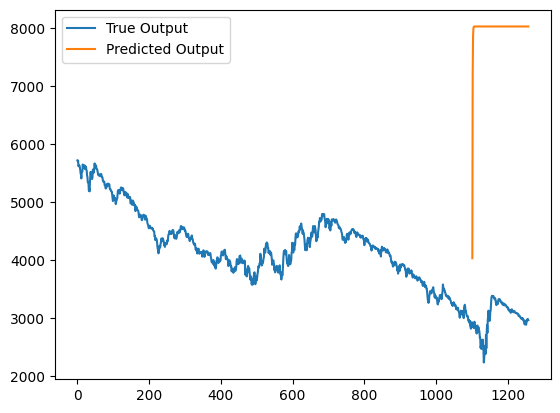

In [51]:
# Parameters
input_size = 1
reservoir_size = 1000
output_size = 1
tmin = 200

# Generate data
input = np.asarray(data[:1100]).reshape(-1,1)
output = np.asarray(data[1:1101]).reshape(-1,1)
# Initialize reservoir
reservoir = Reservoir(input_size, reservoir_size, output_size, tmin=tmin, spectral_radius=1, sparsity=0.95, seed=42, reservoir_values_range = 1)

# Train reservoir
reservoir.train(input, output, reg=0.01)

# Test reservoir (autonomous evolution)
predictions = reservoir.predict(np.asarray(data[1101:]).reshape(-1,1), len(data[1101:]))
# Plot results
import matplotlib.pyplot as plt
start_idx = 1101
prediction_range = np.arange(start_idx, start_idx + len(predictions))
# Create a range for predictions starting at 1101
prediction_range = np.arange(start_idx, start_idx + len(predictions))

# Plot the full true data series
plt.plot(np.arange(len(data)), data, label='True Output')

# Plot the predictions starting at index 1101
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()

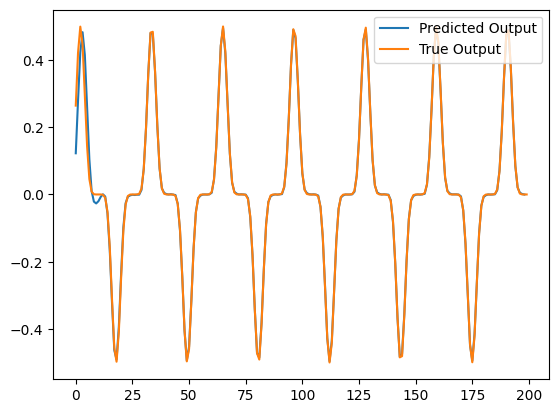

In [53]:
# Input/Output Definition
def generate_data(tsteps):
    u = np.sin(np.arange(tsteps) / 5)
    yteach = 0.5 * u**7
    return u, yteach


# Parameters
input_size = 1
reservoir_size = 200
output_size = 1
tsteps = 300
tmin = 10

# Generate data
u, yteach = generate_data(tsteps)

# Initialize reservoir
reservoir = Reservoir(input_size, reservoir_size, output_size, tmin=tmin, spectral_radius=1.2, sparsity=0.05, seed=42, reservoir_values_range = 1)

# Train reservoir
reservoir.train(u[:100].reshape(-1, 1), yteach[:100].reshape(-1, 1), reg=0.01)

# Test reservoir (autonomous evolution)
predictions = reservoir.predict(u[101:].reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.plot(predictions, label='Predicted Output')
plt.plot(yteach[100:], label='True Output')
plt.legend()
plt.show()